In [3]:
import numpy as np
import pandas as pd
import os
from glob import glob
from skimage.io import imread
import gc
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print(os.listdir("../input/histopathologic-cancer-detection"))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [4]:
base_tile_dir = '../input/histopathologic-cancer-detection/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir, '*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
df_data = df.merge(labels, on="id")

In [5]:
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


In [6]:
SAMPLE_SIZE = 80000
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state=101)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state=101)
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)


In [7]:
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf), exist_ok=True)

In [8]:
df_data.set_index('id', inplace=True)


In [9]:
for image in df_train['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image, 'label'])
    src = os.path.join(base_tile_dir, fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image, 'label'])
    src = os.path.join(base_tile_dir, fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [10]:
IMAGE_SIZE = 96
train_batch_size = 32
val_batch_size = 32

datagen = ImageDataGenerator(preprocessing_function=lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      batch_size=val_batch_size,
                                      class_mode='binary')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(32, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])


In [13]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)


In [14]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=13,
                    callbacks=[reducel, earlystopper])

Epoch 1/13


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-17 20:19:11.930945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-07-17 20:19:11.931021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-07-17 20:19:11.931031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-07-17 20:19:11.931039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-07-17 20:19:11.931047: E external/local_xla/xla/service/gpu/buffer_comp

   3/4500 ━━━━━━━━━━━━━━━━━━━━ 2:37 35ms/step - accuracy: 0.5469 - loss: 1.0343   

I0000 00:00:1721247559.884418     135 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4500/4500 ━━━━━━━━━━━━━━━━━━━━ 247s 51ms/step - accuracy: 0.7884 - loss: 0.4681 - val_accuracy: 0.7577 - val_loss: 0.5746 - learning_rate: 0.0100
Epoch 2/13
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 231s 51ms/step - accuracy: 0.8503 - loss: 0.3517 - val_accuracy: 0.8777 - val_loss: 0.2935 - learning_rate: 0.0100
Epoch 3/13
4498/4500 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8803 - loss: 0.2966
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 226s 50ms/step - accuracy: 0.8803 - loss: 0.2966 - val_accuracy: 0.7942 - val_loss: 0.4335 - learning_rate: 0.0100
Epoch 4/13
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 226s 50ms/step - accuracy: 0.9027 - loss: 0.2456 - val_accuracy: 0.9114 - val_loss: 0.2230 - learning_rate: 1.0000e-03
Epoch 5/13
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 225s 50ms/step - accuracy: 0.9103 - loss: 0.2309 - val_accuracy: 0.9090 - val_loss: 0.2227 - learning_rate: 1.0000e-03
Epoch 6/13
4498/4500 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accurac

In [15]:
y_pred_keras = model.predict(val_gen, steps=len(df_val))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step   


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


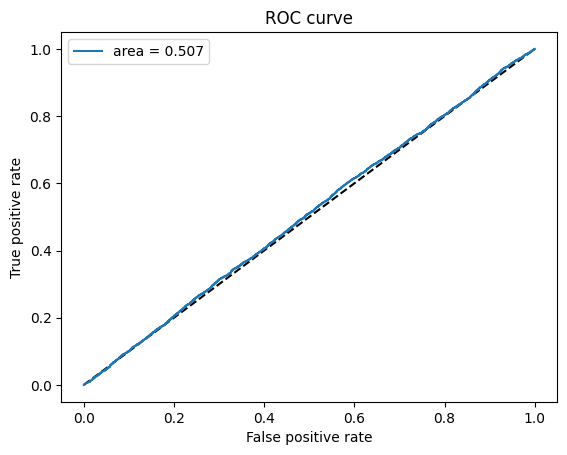

Indexes: 0 - 5000
141/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2024-07-17 20:56:27.686862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35384: 5.56886, expected 4.88914
2024-07-17 20:56:27.686927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35405: 5.71776, expected 5.03803
2024-07-17 20:56:27.686942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35407: 5.49677, expected 4.81704
2024-07-17 20:56:27.686956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35408: 5.65397, expected 4.97424
2024-07-17 20:56:27.686969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35417: 5.33792, expected 4.65819
2024-07-17 20:56:27.686995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35426: 5.66103, expected 4.9813
2024-07-17 20:56:27.687005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35427: 4.69272, expected 4.01299
2024-07-17 20:56:27.687016: 

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Indexes: 5000 - 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 10000 - 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 15000 - 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 20000 - 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 25000 - 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 30000 - 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 35000 - 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 40000 - 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 45000 - 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 50000 - 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 55000 - 60000
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2024-07-17 21:04:40.127643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29007: 4.4263, expected 3.88178
2024-07-17 21:04:40.127703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29623: 4.31422, expected 3.7697
2024-07-17 21:04:40.127720: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31593: 4.14511, expected 3.60059
2024-07-17 21:04:40.127733: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32672: 4.2334, expected 3.68887
2024-07-17 21:04:40.127857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61854: 6.27065, expected 5.51022
2024-07-17 21:04:40.127865: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61866: 6.53341, expected 5.77298
2024-07-17 21:04:40.127873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61912: 6.49767, expected 5.73724
2024-07-17 21:04:40.127881: E 

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [17]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
base_test_dir = '../input/histopathologic-cancer-detection/test/'
test_files = glob(os.path.join(base_test_dir, '*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i" % (idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])

In [18]:
submission.to_csv("submission.csv", index=False, header=True)
